In [3]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import yaml
from tqdm import tqdm
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import plotly.subplots as sp
import plotly.graph_objects as go
import math

In [50]:
"""import os

actual_dir = os.getcwd()
prev_dir = os.path.dirname(actual_dir)
os.chdir(prev_dir)
print("Bieżący katalog roboczy:", os.getcwd())
"""

'import os\n\nactual_dir = os.getcwd()\nprev_dir = os.path.dirname(actual_dir)\nos.chdir(prev_dir)\nprint("Bieżący katalog roboczy:", os.getcwd())\n'

In [19]:

# config_path = os.path.join('configs/1_per.yaml')
config_path = os.path.join('config.yaml')

with open(config_path) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    
METADATA_DATASET = cfg['path_metadata']
ACCOUNT_INFO_DATASET = cfg['path_influencers']
IMAGES_DATASET = cfg['path_image']
POPULAR_DIRECTION = cfg['path_metadata_popular']


## Metadata processing

In [22]:
data = []
for filename in tqdm(os.listdir(METADATA_DATASET)):
    file_path = os.path.join(METADATA_DATASET, filename)
    with open(file_path, "r") as file:
        content = file.read()
        content_json = json.loads(content)
        likes = content_json["edge_media_preview_like"]["count"]
        id = content_json["id"]
        data.append({"filename": filename, "likes": likes, "post_id": id})
df = pd.DataFrame(data)

100%|██████████| 97481/97481 [00:30<00:00, 3228.03it/s]


In [23]:
likes_df = df


In [24]:
#likes_df = pd.DataFrame(data)
likes_df["Username"] = likes_df["filename"].apply(lambda x: x.split("-")[0])


## Account info processing

In [25]:
followers_df = pd.read_csv(ACCOUNT_INFO_DATASET, sep="\t", skiprows=[1]).drop(
    ["#Followees", "#Posts", "Category"], axis=1
)
followers_df = followers_df.rename(columns={"#Followers": "#Followers"})
followers_df

,Username,#Followers
0,adila_makeup,13424
1,hairbycourtneyd,1200
2,mandiglitter,7557
3,ldelabios,1781
4,legendvrry,22018
...,...,...
333,unfinished_man,10847
334,babsdirection,3634
335,iamjennsullivan,3673
336,ilianainocencio,1327


In [26]:
results_df = likes_df.merge(followers_df, on="Username", how="right")
results_df

,filename,likes,post_id,Username,#Followers
0,adila_makeup-1647957326634012358.info,97,1647957326634012358,adila_makeup,13424
1,adila_makeup-1649426664381566808.info,94,1649426664381566808,adila_makeup,13424
2,adila_makeup-1652361388750034712.info,71,1652361388750034712,adila_makeup,13424
3,adila_makeup-1653008372389621364.info,80,1653008372389621364,adila_makeup,13424
4,adila_makeup-1654650798795401360.info,71,1654650798795401360,adila_makeup,13424
...,...,...,...,...,...
97476,bluebird_cosplay-2032781075671895866.info,73,2032781075671895866,bluebird_cosplay,1063
97477,bluebird_cosplay-2034930790496532244.info,96,2034930790496532244,bluebird_cosplay,1063
97478,bluebird_cosplay-2040305426025446175.info,132,2040305426025446175,bluebird_cosplay,1063
97479,bluebird_cosplay-2040644117868813619.info,129,2040644117868813619,bluebird_cosplay,1063


In [27]:
results_df = likes_df.merge(followers_df, on="Username", how="right")
results_df = results_df.set_index("post_id")

## Popularity metrics

In [28]:
results_df["log_likes"] = results_df.apply(
    lambda x: math.log(x["likes"]) if x["likes"] > 0 else 0, axis=1
)
results_df["log_followers"] = results_df.apply(
    lambda x: math.log(x["#Followers"]) if x["#Followers"] > 0 else 0, axis=1
)

In [29]:
X = results_df[["log_followers"]]  # Zmienna niezależna (log_followers)
y = results_df["log_likes"]  # Zmienna zależna (log_likes)


In [30]:
results_df["engagement_rate"] = results_df.apply(
    lambda x: (x["likes"] / x["#Followers"]) * 100, axis=1
)
mean_engagement_rate = results_df["engagement_rate"].mean()
median_engagement_rate = results_df["engagement_rate"].median()

mean_likes_per_user = results_df.groupby("Username")["likes"].mean()
std_likes_per_user = results_df.groupby("Username")["likes"].std()
results_df["mean_likes"] = results_df["Username"].map(mean_likes_per_user)
results_df["std_likes"] = results_df["Username"].map(std_likes_per_user)
results_df["z_score"] = results_df.apply(
    lambda x: (x["likes"] - x["mean_likes"]) / x["std_likes"], axis=1
)

mean_z_socre = results_df["z_score"].mean()
median_z_score = results_df["z_score"].median()

results_df["popular_Hubert"] = results_df.apply(
    lambda x: x["engagement_rate"] > 40 and x["z_score"] > 4, axis=1
)

results_df["popular_engagement_mean"] = results_df.apply(
    lambda x: x["engagement_rate"] > mean_engagement_rate, axis=1
)

results_df["popular_engagement_median"] = results_df.apply(
    lambda x: x["engagement_rate"] > median_engagement_rate, axis=1
)

results_df["popular_z_score_mean"] = results_df.apply(
    lambda x: x["z_score"] > mean_z_socre, axis=1
)
results_df["popular_z_score_median"] = results_df.apply(
    lambda x: x["z_score"] > median_z_score, axis=1
)

In [37]:
columns_labels = ['popular_Hubert', 'popular_engagement_mean', 'popular_engagement_median', 'popular_z_score_mean', 'popular_z_score_median']

# Przygotowanie danych
X = results_df[["log_followers"]]  # Zmienna niezależna (log_followers)
y = results_df["log_likes"]  # Zmienna zależna (log_likes)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

# Trenowanie modelu
model.fit(X, y)

# Przewidywanie wartości na podstawie modelu
results_df["predicted_log_likes"] = model.predict(X)
results_df["popular_regression"] = results_df.apply(
    lambda x: x["log_likes"] > x["predicted_log_likes"], axis=1
)

In [41]:
len(results_df)


97481

In [43]:
len(results_df[results_df["popular_regression"] == True]) / len(results_df[results_df["popular_regression"] == False])



1.1925057915926318

## Visualization

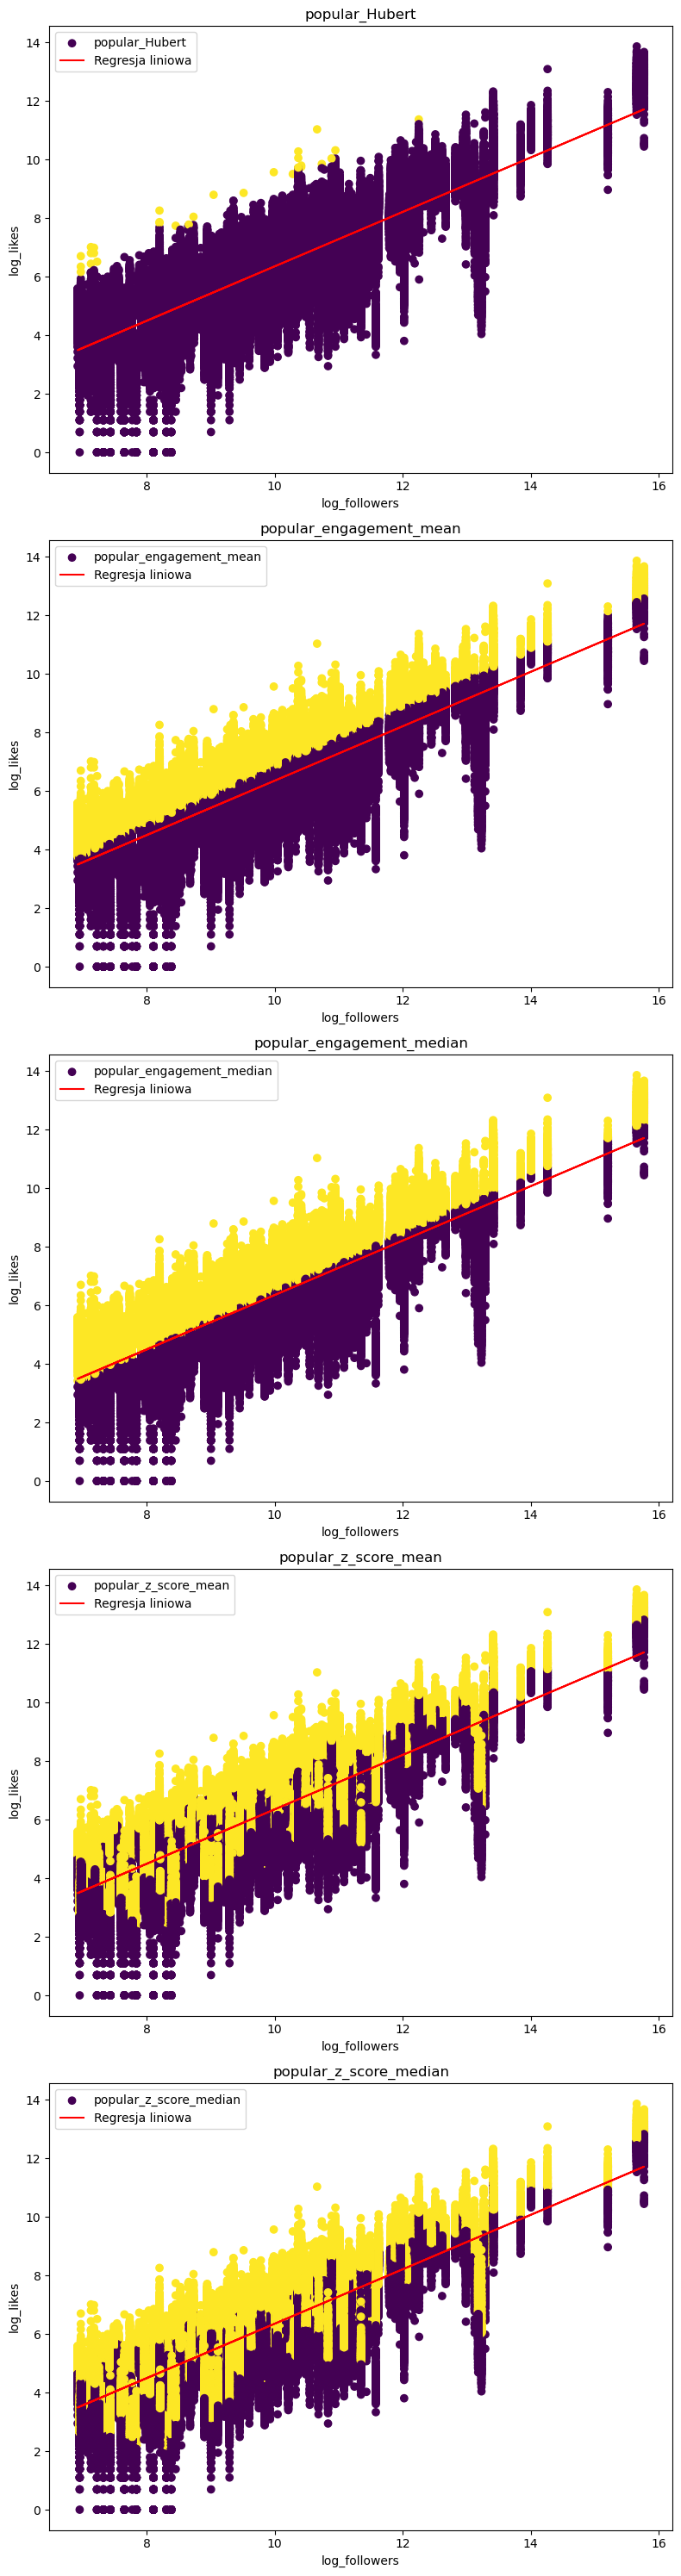

In [44]:
fig, axes = plt.subplots(nrows=len(columns_labels), ncols=1, figsize=(8, 6 * len(columns_labels)))

# Iteracja po kolumnach i tworzenie podwykresów
for i, column_label in enumerate(columns_labels, start=1):
    column_data = results_df[column_label]
    
    # Wykres punktowy z różnymi kolorami punktów
    scatter = axes[i-1].scatter(results_df["log_followers"], results_df["log_likes"],
                                c=column_data, cmap='viridis', label=column_label)
    
    # Dodanie linii regresji
    axes[i-1].plot(results_df["log_followers"], results_df["predicted_log_likes"], color='red', label='Regresja liniowa')
    
    # Ustawienia osi i etykiet
    axes[i-1].set_xlabel('log_followers')
    axes[i-1].set_ylabel('log_likes')
    axes[i-1].set_title(column_label)
    axes[i-1].legend()

# Ustawienia layoutu
plt.tight_layout()
plt.show()


## Save

In [48]:
results_df.head()

,filename,likes,Username,#Followers,log_likes,log_followers,engagement_rate,mean_likes,std_likes,z_score,popular_Hubert,popular_engagement_mean,popular_engagement_median,popular_z_score_mean,popular_z_score_median,predicted_log_likes,popular_regression
post_id,,,,,,,,,,,,,,,,,
1647957326634012358,adila_makeup-1647957326634012358.info,97,adila_makeup,13424,4.574711,9.504799,0.722586,212.692308,243.186203,-0.475735,False,False,False,False,False,5.895762,False
1649426664381566808,adila_makeup-1649426664381566808.info,94,adila_makeup,13424,4.543295,9.504799,0.700238,212.692308,243.186203,-0.488072,False,False,False,False,False,5.895762,False
1652361388750034712,adila_makeup-1652361388750034712.info,71,adila_makeup,13424,4.262680,9.504799,0.528903,212.692308,243.186203,-0.582649,False,False,False,False,False,5.895762,False
1653008372389621364,adila_makeup-1653008372389621364.info,80,adila_makeup,13424,4.382027,9.504799,0.595948,212.692308,243.186203,-0.545641,False,False,False,False,False,5.895762,False
1654650798795401360,adila_makeup-1654650798795401360.info,71,adila_makeup,13424,4.262680,9.504799,0.528903,212.692308,243.186203,-0.582649,False,False,False,False,False,5.895762,False


In [49]:
os.makedirs(POPULAR_DIRECTION, exist_ok=True)

for post_id, row in tqdm(results_df.iterrows(), desc="Zapisywanie plików .info", total=results_df.shape[0]):
    data_dict = {'post_map': f'{post_id}.info'}
    data_dict.update({column: value for column, value in zip(results_df.columns, row)})
    
    # Tworzenie nazwy pliku zgodnie z wymaganiami
    filename = f"{row['Username']}-{post_id}.info"
    
    # Pełna ścieżka do pliku
    file_path = os.path.join(POPULAR_DIRECTION, filename)
    
    # Zapisz wiersz do pliku JSON
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data_dict, file)  # 'records' formatuje dane jako listę słowników


Zapisywanie plików .info: 100%|██████████| 97481/97481 [01:02<00:00, 1550.85it/s]
